# L10: Model Evaluation 3 -- Cross-Validation and Model Selection

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Author: Sebastian Raschka

Last updated: 2021-11-08

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.29.0

numpy     : 1.21.2
mlxtend   : 0.19.0
matplotlib: 3.4.3
sklearn   : 1.0



In [2]:
import numpy as np
import matplotlib.pyplot as plt

<p style="margin-bottom:5cm;"></p>


## GridSearch

- For hyperparameter tuning and model selection, `GridSearchCV` is really useful

In [3]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)

In [4]:
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 96.09%
Best Params: {'criterion': 'gini', 'max_depth': 3}


In [5]:
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

0.653846153846154 {'criterion': 'gini', 'max_depth': 1}
0.9121794871794873 {'criterion': 'gini', 'max_depth': 2}
0.9608974358974359 {'criterion': 'gini', 'max_depth': 3}
0.951923076923077 {'criterion': 'gini', 'max_depth': 4}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 5}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 6}
0.9602564102564102 {'criterion': 'gini', 'max_depth': None}
0.653846153846154 {'criterion': 'entropy', 'max_depth': 1}
0.9121794871794873 {'criterion': 'entropy', 'max_depth': 2}
0.9608974358974359 {'criterion': 'entropy', 'max_depth': 3}
0.9365384615384617 {'criterion': 'entropy', 'max_depth': 4}
0.9448717948717948 {'criterion': 'entropy', 'max_depth': 5}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': 6}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': None}


- We an summarize the results in a heatmap, but note that this only works if you have 1 or 2 hyperparameters to consider

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

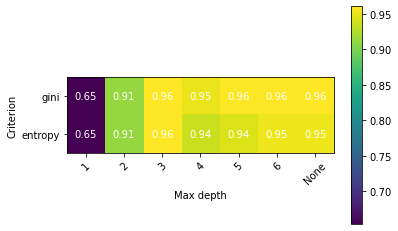

In [7]:
from mlxtend.plotting import heatmap
import numpy as np
import pandas as pd

grid = np.zeros((2, 7))
grid[0, :] = gs.cv_results_['mean_test_score'][:7]
grid[1, :] = gs.cv_results_['mean_test_score'][7:]


heatmap(grid, 
        column_names=[1, 2, 3, 4, 5, 6, "None"], 
        row_names=['gini', 'entropy'])
plt.ylabel('Criterion')
plt.xlabel('Max depth')
plt.show()

- After running `GridSearchCV`, we would fit a model with the best settings (hyperparameters on the whole training set
- By default, `GridSearchCV` already does this for us (unless, we set `refit=False`), so that we can evaluate the performance of the model on the test set

In [8]:
# gs.best_estimator_.fit(X_train, y_train)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 95.65%


<p style="margin-bottom:5cm;"></p>

- `GridSearchCV` is also compatible with the .632-Bootstrap iterator we defined earlier

In [9]:
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import BootstrapOutOfBag


param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 95.12%
Best Params: {'criterion': 'entropy', 'max_depth': 3}
Accuracy: 95.65%


In [10]:
best_model_idx = np.argmin(gs.cv_results_['rank_test_score'])
scores = [gs.cv_results_['split%d_test_score' % i][best_model_idx] for i in range(200)]

bootstrap_percentile_lower = np.percentile(scores, 2.5)
bootstrap_percentile_upper = np.percentile(scores, 97.5)
print('95%% CI: [ %.2f, %.2f ]' 
      % (100*round(bootstrap_percentile_lower, 4), 
         100*round(bootstrap_percentile_upper, 4)))

95% CI: [ 89.12, 100.00 ]


<p style="margin-bottom:5cm;"></p>

- Note that feature scaling is unnecessary when we are using decsion trees, however it DOES matter in most other learning algorithms, including k-Nearest-Neighbors
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and standard deviation in context of z-score normalization) on the training fold to scale the training AND test fold in a given iteration
- To make this more convenient, this is where scikit-learn's `Pipeline` class (or `make_pipeline` function) comes in handy as the next cell demonstrates

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(), 
                     KNeighborsClassifier())

param_grid = [{'kneighborsclassifier__n_neighbors': list(range(1, 16)),
               'kneighborsclassifier__p': [1, 2]}]


gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 94.78%
Best Params: {'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__p': 1}
Accuracy: 91.30%


<br>
<br>
<br>
<br>

## Randomized Search

- Here, each setting is sampled from a distribution (discrete or continuous) over possible parameter values
- Instead of running all combinations exhaustively like in GridSearch, a budget is specified (`n_iter` specifies the number of candidates to evaluate)

### ParamSampler

- To explain these concepts, let's take a look at the `ParamSampler` first, which is used under the hood of the `RandomizedSearchCV`; it will help us building some intuition.

As we can see in the example below, lists are also supported; they will behave like gridsearch

In [13]:
from sklearn.model_selection import ParameterSampler


d = {'parameter 1': [1, 2, 3], 
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 2': 'a', 'parameter 1': 1},
 {'parameter 2': 'b', 'parameter 1': 1},
 {'parameter 2': 'a', 'parameter 1': 2},
 {'parameter 2': 'b', 'parameter 1': 2},
 {'parameter 2': 'a', 'parameter 1': 3},
 {'parameter 2': 'b', 'parameter 1': 3}]

- We can define probability distributions using SciPy's selection of distributions (https://docs.scipy.org/doc/scipy/reference/stats.html).

- Consider a discrete random uniform distribution for parameter 1 (note that in this case, there is a sampling with replacement from the distribution)

In [15]:
import scipy.stats

d = {'parameter 1': scipy.stats.randint(low=1, high=4), # integer between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'a'},
 {'parameter 1': 1, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'a'}]

- below is an example for sampling from a uniform continuous distribution:

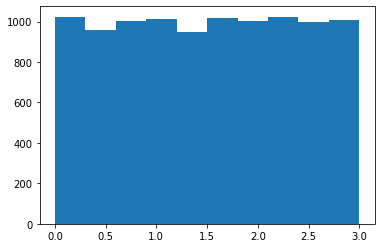

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.hist(scipy.stats.uniform(loc=0, scale=3).rvs(10000))
plt.show()

In [17]:
d = {'parameter 1': scipy.stats.uniform(loc=0, scale=3), # float between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 2.089407556793585, 'parameter 2': 'a'},
 {'parameter 1': 1.285412778560477, 'parameter 2': 'a'},
 {'parameter 1': 1.6539443072486737, 'parameter 2': 'b'},
 {'parameter 1': 1.473356800297792, 'parameter 2': 'b'},
 {'parameter 1': 2.9422925951538463, 'parameter 2': 'a'},
 {'parameter 1': 1.7390828910678304, 'parameter 2': 'b'},
 {'parameter 1': 1.1763525545824516, 'parameter 2': 'a'},
 {'parameter 1': 1.8819510280128502, 'parameter 2': 'b'},
 {'parameter 1': 1.3157167340388733, 'parameter 2': 'b'},
 {'parameter 1': 2.084265531555807, 'parameter 2': 'a'}]

<br>
<br>
<br>
<br>

### RandomizedSeachCV example

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [20]:
gbm = HistGradientBoostingClassifier(random_state=123)

d = {'learning_rate': [0.1],
     'max_depth': scipy.stats.randint(low=3, high=10),
     'l2_regularization': scipy.stats.uniform(loc=0, scale=1)}

rcv = RandomizedSearchCV(estimator=gbm,
                         param_distributions=d, 
                         n_iter=50,
                         cv=10,
                         refit=True,
                         random_state=123,
                         n_jobs=-1)

rcv.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (rcv.best_score_*100))
print('Best Params:', rcv.best_params_)

Best Accuracy: 94.29%
Best Params: {'l2_regularization': 0.9807641983846155, 'learning_rate': 0.1, 'max_depth': 3}


### Randomized search with successive halving

In [21]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [22]:
gbm = HistGradientBoostingClassifier(random_state=123)

search = HalvingRandomSearchCV(
    estimator=gbm, 
    param_distributions=d,
    n_candidates='exhaust',
    resource='n_samples',
    cv=10,
    factor=2,
    random_state=123,
    n_jobs=-1)


search.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (search.best_score_*100))
print('Best Params:', search.best_params_)

Best Accuracy: 94.85%
Best Params: {'l2_regularization': 0.4284709261868257, 'learning_rate': 0.1, 'max_depth': 5}
